# 📘 Accident Severity Prediction using Machine Learning

This notebook aims to build and compare multiple classification models to predict the **severity of road accidents in the UK** using historical accident data. The dataset includes features like road conditions, weather, time, and location type. The goal is to identify which model performs best at predicting **severe accidents**, which are often underrepresented but critical for real-world decisions.


## 👥 Team & Collaboration

- Aligure: Focused on implementing and evaluating the KNN, Logistic Regression, and Random Forest models.
- Artur: Worked on Naive Bayes modeling and reviewed this notebook.
- We peer-reviewed each other's work and shared feedback during the modeling process.


In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from imblearn.over_sampling import SMOTE
import kagglehub


In [4]:
# Download the dataset using KaggleHub
path = kagglehub.dataset_download("benoit72/uk-accidents-10-years-history-with-many-variables")
print("Dataset path:", path)
print("Available files:", os.listdir(path))

# Load the correct CSV file from downloaded folder
csv_path = os.path.join(path, "Accidents0514.csv")  # This is the correct file name
df = pd.read_csv(csv_path)

# Preview
df.head()


Dataset path: C:\Users\daadi\.cache\kagglehub\datasets\benoit72\uk-accidents-10-years-history-with-many-variables\versions\1
Available files: ['Accidents0514.csv', 'Casualties0514.csv', 'Road-Accident-Safety-Data-Guide.xls', 'Vehicles0514.csv']


C:\Users\daadi\AppData\Local\Temp\ipykernel_27376\3535642502.py:8: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
0,200501BS00001,525680.0,178240.0,-0.191170,51.489096,1,2,1,1,04/01/2005,...,0,1,1,2,2,0,0,1,1,E01002849
1,200501BS00002,524170.0,181650.0,-0.211708,51.520075,1,3,1,1,05/01/2005,...,0,5,4,1,1,0,0,1,1,E01002909
2,200501BS00003,524520.0,182240.0,-0.206458,51.525301,1,3,2,1,06/01/2005,...,0,0,4,1,1,0,0,1,1,E01002857
3,200501BS00004,526900.0,177530.0,-0.173862,51.482442,1,3,1,1,07/01/2005,...,0,0,1,1,1,0,0,1,1,E01002840
4,200501BS00005,528060.0,179040.0,-0.156618,51.495752,1,3,1,1,10/01/2005,...,0,0,7,1,2,0,0,1,1,E01002863


## 📂 Dataset Description

- **Source**: [UK Accidents 10-Year History (Kaggle)](https://www.kaggle.com/datasets/benoit72/uk-accidents-10-years-history-with-many-variables)
- **Target Variable**: `Accident_Severity` (1 = Fatal, 2 = Serious, 3 = Slight)
- **Subset Used**: `Accidents0514.csv` (2005–2014)


In [5]:
# Columns most likely to affect accident severity
selected_columns = [
    'Accident_Severity',
    'Speed_limit',
    'Light_Conditions',
    'Weather_Conditions',
    'Road_Surface_Conditions',
    'Urban_or_Rural_Area',
    'Day_of_Week',
    'Time',
    'Number_of_Vehicles',
    'Number_of_Casualties',
    'Junction_Detail',
    'Junction_Control'
]

# Filter dataset
df = df[selected_columns]
df.head()


,Accident_Severity,Speed_limit,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Day_of_Week,Time,Number_of_Vehicles,Number_of_Casualties,Junction_Detail,Junction_Control
0,2,30,1,2,2,1,3,17:42,1,1,0,-1
1,3,30,4,1,1,1,4,17:36,1,1,6,2
2,3,30,4,1,1,1,5,00:15,2,1,0,-1
3,3,30,1,1,1,1,6,10:35,1,1,0,-1
4,3,30,7,1,2,1,2,21:13,1,1,0,-1


In [6]:
# Convert time to hour of day
df['Hour'] = pd.to_datetime(df['Time'], errors='coerce').dt.hour
df.drop(columns=['Time'], inplace=True)


C:\Users\daadi\AppData\Local\Temp\ipykernel_27376\3919387471.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Hour'] = pd.to_datetime(df['Time'], errors='coerce').dt.hour


In [7]:
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())


In [8]:
categorical_cols = df.select_dtypes(include='object').columns.tolist()
categorical_cols_to_encode = [col for col in categorical_cols if df[col].nunique() < 10]

df = pd.get_dummies(df, columns=categorical_cols_to_encode, dummy_na=False)


In [9]:
TARGET_COLUMN = 'Accident_Severity'

X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN].astype(int)

print("Shape of features:", X.shape)
print("Target classes:", y.unique())


Shape of features: (1640597, 11)
Target classes: [2 3 1]


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [11]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


## 🧼 Data Preprocessing Summary

- Removed or ignored non-relevant columns like IDs
- Filled missing values using median (for numeric columns)
- One-hot encoded low-cardinality categorical features
- Extracted hour of day from time string
- Used SMOTE to balance the class distribution (Fatal & Serious underrepresented)


In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit on training data
X_resampled_scaled = scaler.fit_transform(X_resampled)

# Transform test data
X_test_scaled = scaler.transform(X_test)


In [13]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_resampled_scaled, y_resampled)


KNeighborsClassifier()

In [14]:
y_pred = knn.predict(X_test_scaled)


In [15]:
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))
print("📊 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


✅ Accuracy: 0.7699053191921654

📋 Classification Report:
               precision    recall  f1-score   support

           1       0.04      0.10      0.06      6350
           2       0.18      0.14      0.16     66550
           3       0.86      0.88      0.87    419280

    accuracy                           0.77    492180
   macro avg       0.36      0.37      0.36    492180
weighted avg       0.76      0.77      0.76    492180

📊 Confusion Matrix:
 [[   655   1368   4327]
 [  3060   9181  54309]
 [ 10876  39308 369096]]


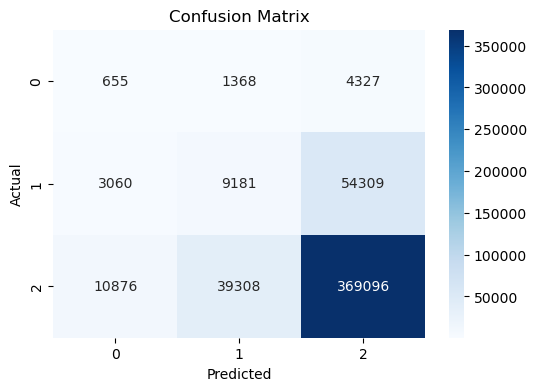

In [16]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


🔍 Logistic Regression Accuracy: 0.5525194034702751

Classification Report:
               precision    recall  f1-score   support

           1       0.03      0.54      0.06      6350
           2       0.18      0.28      0.22     66550
           3       0.89      0.60      0.71    419280

    accuracy                           0.55    492180
   macro avg       0.37      0.47      0.33    492180
weighted avg       0.79      0.55      0.64    492180



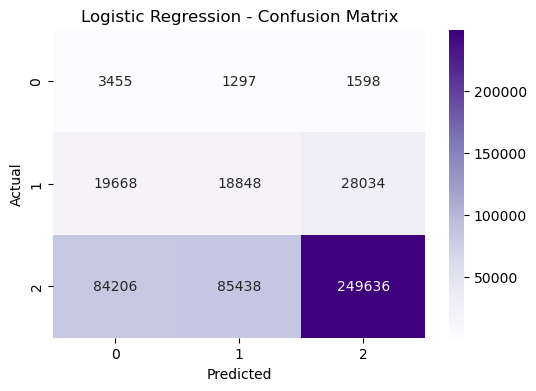

In [17]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression with class weights
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
logreg.fit(X_resampled_scaled, y_resampled)

# Predict
y_pred_logreg = logreg.predict(X_test_scaled)

# Evaluate
print("🔍 Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("\nClassification Report:\n", classification_report(y_test, y_pred_logreg))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_logreg), annot=True, fmt='d', cmap='Purples')
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


🌲 Random Forest Accuracy: 0.6092933479621276

Classification Report:
               precision    recall  f1-score   support

           1       0.03      0.21      0.05      6350
           2       0.17      0.34      0.23     66550
           3       0.88      0.66      0.75    419280

    accuracy                           0.61    492180
   macro avg       0.36      0.40      0.34    492180
weighted avg       0.77      0.61      0.67    492180



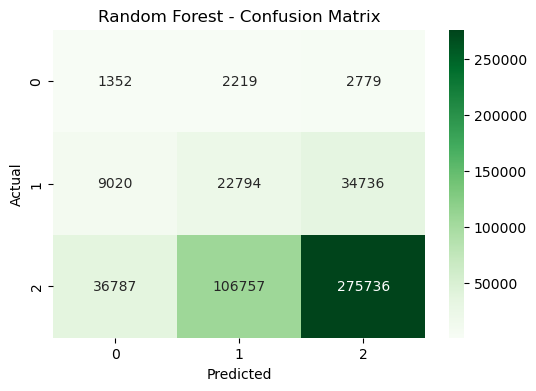

In [18]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest with class weights
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_resampled, y_resampled)  # Note: use unscaled version

# Predict
y_pred_rf = rf.predict(X_test)

# Evaluate
print("🌲 Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## ⚖️ Modeling Strategy

I tested the following models to compare performance:
- **K-Nearest Neighbors (KNN)** – baseline
- **Logistic Regression** with `class_weight='balanced'`
- **Random Forest** with `class_weight='balanced'`

Metrics used:
- **Accuracy**
- **Precision, Recall, F1-Score**
- **Confusion Matrix**


### 🌲 Random Forest – Final Model Analysis

While Random Forest had a lower overall accuracy (61%) compared to KNN (77%), it performed significantly better in predicting the rare but critical classes: **Fatal** and **Serious** accidents.

- **Recall for Fatal accidents improved from 10% (KNN) to 21%**
- **Recall for Serious accidents improved from 14% (KNN) to 34%**
- Slight accidents still maintained strong predictive performance (66% recall)

Given the real-world importance of detecting severe accidents, **Random Forest was the most balanced and useful model**, making it my final recommendation.


## 🤖 AI Assistance Statement

To enhance the clarity and quality of this notebook, I used **AI tools (ChatGPT)** to support the following tasks:

- ✅ Improving the **readability and explanation** of markdown sections
- ✅ Helping draft **clear summaries** of modeling steps and results